In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'customer-clustering:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F3321608%2F5781443%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240126%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240126T070826Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3d4530a14e88256a1b5c5f0734f92c9f92089b95647f413954f295bab711b7ca29666e3dd5efd3ddc1a709e8da354d4d1241d914e95f8810e9ee2f9c180004e53f0d5e9f62f98826d8c7ce121be65855c7cac6937e024d062cd1d6794571ff7dad959bfbb08e704613b99a25ffc53819582fa2bd428294cbdf73992e5fe46fcf28aaeacf742b66574162388c783fa2cedcae5ccb0171a843b7f6aa0b1fbc76e668b9abef68cc1ca8bbf4760c780623581e58a1d6b69129edef1c08efeb0373b72f255c59b3653d2d7d3829150896308c54e89ebe99934494a89ad05a14fc3f4ee4f4ad5b2a4bfbc66f82e872286b029ccb7233bb07052893f04d2f0e46b50589'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1912 bytes downloaded
Downloaded and uncompressed: customer-clustering
Data source import complete.


In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import smtplib
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/kaggle/input/customer-clustering/customer_data.csv', delimiter=',')
df.drop('customer_id', axis=1, inplace=True)
df

,age,gender,income,education,marital_status,spending_score,purchase_history,website_visits,loyalty_points
0,25,M,50000,Bachelor,Single,70,High,10,100
1,35,F,60000,Master,Married,50,Medium,5,50
2,45,F,80000,PhD,Married,80,High,15,200
3,40,M,70000,Master,Single,65,High,8,150
4,30,F,40000,Bachelor,Single,35,Low,3,20
...,...,...,...,...,...,...,...,...,...
392,36,F,52000,Bachelor,Single,52,Medium,6,85
393,40,M,72000,Master,Married,75,High,12,160
394,33,F,55000,Master,Single,48,Medium,7,70
395,45,M,78000,Bachelor,Married,70,High,10,140


# Description and Visualization of Categorical Features

In [4]:
categorical_columns = ['gender', 'education', 'marital_status', 'purchase_history']

for col in categorical_columns:
    unique_values = df[col].unique()
    frequencies = df[col].value_counts()
    print(f"Column: {col}")
    print(f"Unique Values: {unique_values}")
    print(f"Frequencies:\n{frequencies}\n")

Column: gender
Unique Values: ['M' 'F']
Frequencies:
F    214
M    183
Name: gender, dtype: int64

Column: education
Unique Values: ['Bachelor' 'Master' 'PhD']
Frequencies:
Master      159
Bachelor    133
PhD         105
Name: education, dtype: int64

Column: marital_status
Unique Values: ['Single' 'Married']
Frequencies:
Married    236
Single     161
Name: marital_status, dtype: int64

Column: purchase_history
Unique Values: ['High' 'Medium' 'Low']
Frequencies:
High      237
Medium    105
Low        55
Name: purchase_history, dtype: int64



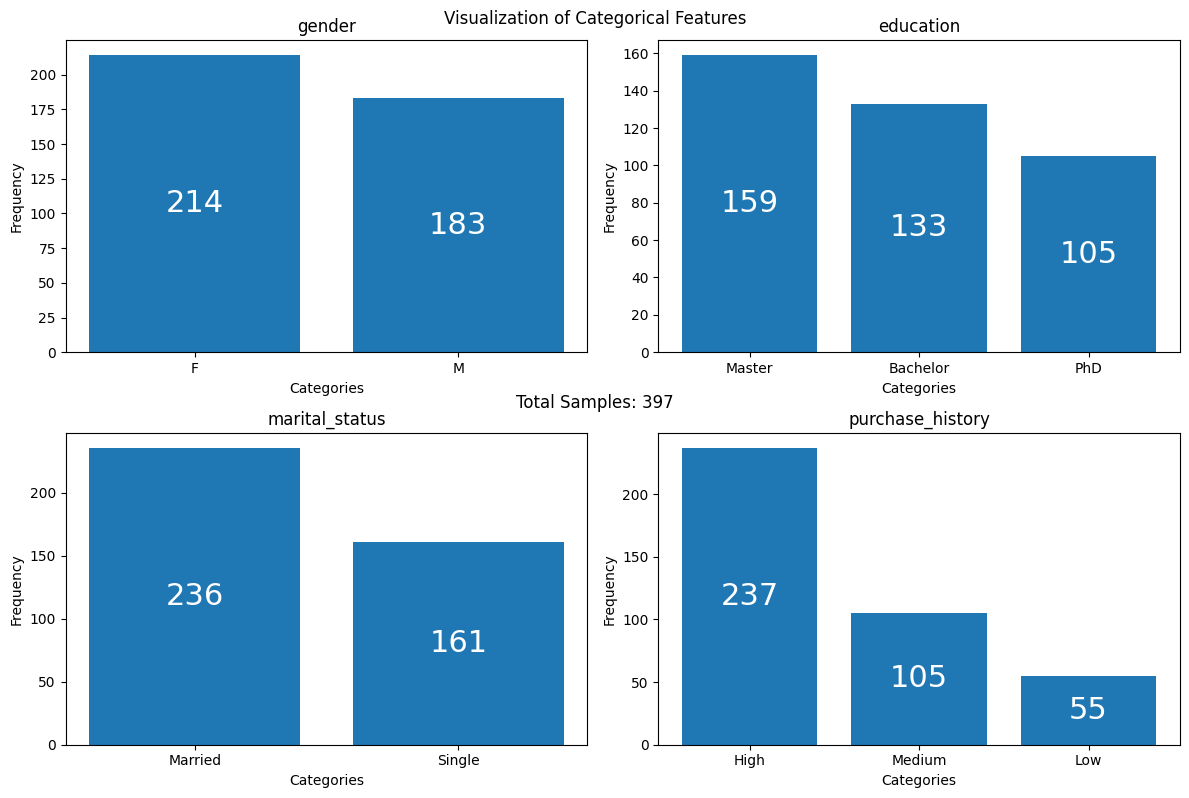

In [5]:
categorical_features = ['gender', 'education', 'marital_status', 'purchase_history']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

for i, col in enumerate(categorical_features):
    ax = axes[i // 2, i % 2]  # Select the current subplot
    frequencies = df[col].value_counts()
    bars = ax.bar(frequencies.index, frequencies.values)
    ax.set_title(f'{col}')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Frequency')

    # Add text annotations for each bar inside the bar
    for bar, freq in zip(bars, frequencies.values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, str(freq),
                ha='center', va='center', color='white', fontsize=22)

total_samples = len(df)
# Add text annotation for the total number of samples at the center
plt.figtext(0.5, 0.5, f'Total Samples: {total_samples}', ha='center', va='center', fontsize=12)

plt.figtext(0.5, 0.98, 'Visualization of Categorical Features', ha='center', va='center', fontsize=12)
# Adjust subplot layout and display
plt.tight_layout()

plt.savefig("Categorical_data_visualization.png", format='png', dpi=900)

# Show the plot
plt.show()
# Save the plot as an image


# Description and Visualization of numerical feature

In [6]:
df.describe().to_csv('description of numeric features.csv', index=True)
df.describe()


,age,income,spending_score,website_visits,loyalty_points
count,397.000000,397.000000,397.000000,397.000000,397.000000
mean,39.020151,67443.324937,64.481108,10.697733,139.307305
std,8.127121,17700.794282,17.543676,6.581986,89.318895
min,25.000000,40000.000000,35.000000,3.000000,20.000000
25%,31.000000,55000.000000,48.000000,6.000000,70.000000
50%,39.000000,60000.000000,65.000000,9.000000,110.000000
75%,46.000000,80000.000000,80.000000,15.000000,210.000000
max,57.000000,120000.000000,98.000000,30.000000,350.000000


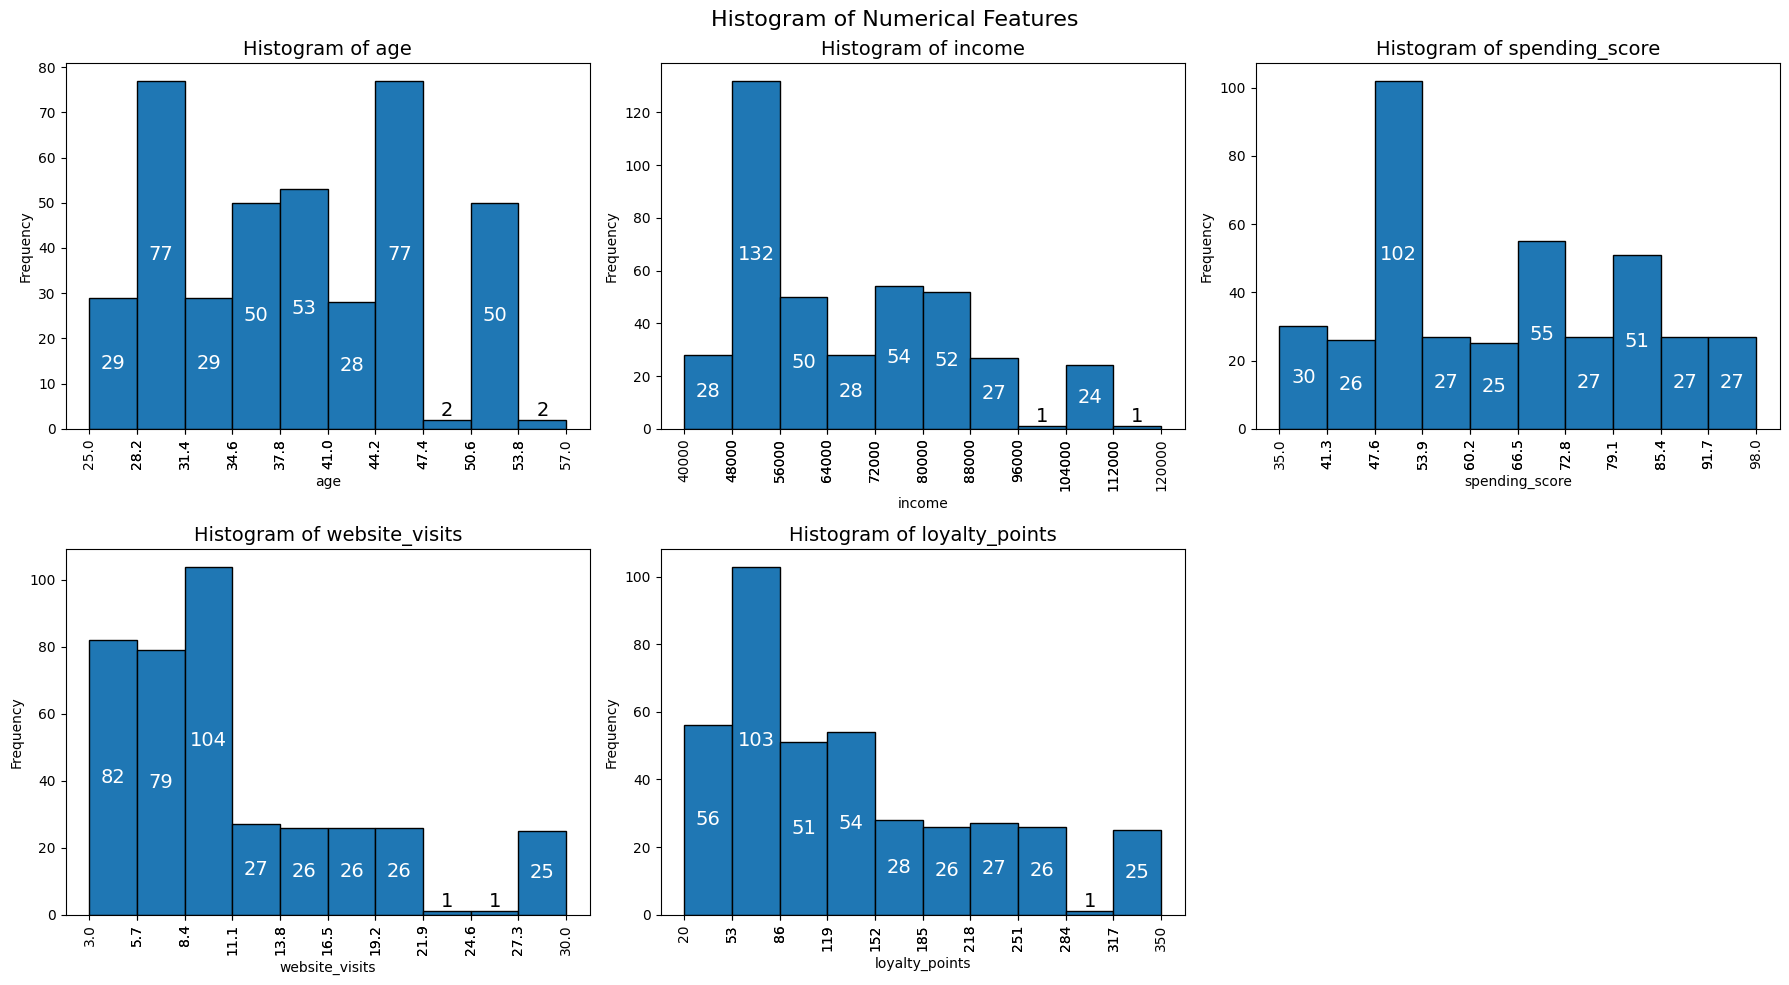

In [7]:
# Create subplots for numeric features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Flatten the axes array for easier iteration
axes = axes.ravel()

# Numeric feature names
numeric_features = ['age', 'income', 'spending_score', 'website_visits', 'loyalty_points']

for i, feature in enumerate(numeric_features):
        ax = axes[i]
        values, edges, patches = ax.hist(df[feature], bins=10, edgecolor='k')
        ax.set_title(f'Histogram of {feature}', fontsize=14)
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.set_xticks([])
        # Display values at the edges of every bin
        bins = []
        for i in range(len(edges) - 1):
            bin_start = edges[i]
            bin_end = edges[i + 1]

            bins.append(bin_start)
            bins.append(bin_end)
            bin_center = (bin_start + bin_end) / 2
            freq = values[i]
            if int(freq) > 10:
                ax.text(bin_center, freq / 2, str(int(freq)),
                        ha='center', va='center', color='white',  fontsize=14)
            else:
                ax.text(bin_center, freq, str(int(freq)),
                        ha='center', va='bottom',  fontsize=14)

        ax.set_xticks(bins)
        ax.tick_params(axis='x', labelrotation=90)

fig.delaxes(axes[5])

# Add a title to the whole plot
fig.suptitle("Histogram of Numerical Features", fontsize=16, y=0.98)  # "y" adjusts the vertical position of the title

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot as an image
plt.savefig("histogram_numerical_features.png", format='png', dpi=900)

# Show the plot
plt.show()

# visualization of all features

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def visualize_data(df, fig_name, numeric_features=[], categorical_features=[]):
    # Create subplots for numeric features
    fig, axes = plt.subplots(3, 3, figsize=(20, 14)) #change no. of subplos to be suitable
    axes = axes.ravel()

    fig.suptitle(f'{fig_name}', fontsize=22)

    for i, feature in enumerate(numeric_features):
        ax = axes[i]
        values, edges, patches = ax.hist(df[feature], bins=10, edgecolor='k')
        ax.set_title(f'Histogram of {feature}', fontsize=14)
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.set_xticks([])
        # Display values at the edges of every bin
        bins = []
        for i in range(len(edges) - 1):
            bin_start = edges[i]
            bin_end = edges[i + 1]

            bins.append(bin_start)
            bins.append(bin_end)
            bin_center = (bin_start + bin_end) / 2
            freq = values[i]
            if int(freq) > 10:
                ax.text(bin_center, freq / 2, str(int(freq)),
                        ha='center', va='center', color='white',  fontsize=14)
            else:
                ax.text(bin_center, freq, str(int(freq)),
                        ha='center', va='bottom',  fontsize=14)

        ax.set_xticks(bins)
        ax.tick_params(axis='x', labelrotation=90)

    for i, col in enumerate(categorical_features):
        ax = axes[i + len(numeric_features)]
        frequencies = df[col].value_counts()
        bars = ax.bar(frequencies.index, frequencies.values)
        ax.set_title(f'{col}', fontsize=14)
        ax.set_xlabel('Categories')
        ax.set_ylabel('Frequency')

        for bar, freq in zip(bars, frequencies.values):
            if freq > 10:
                ax.text(bar.get_x() + bar.get_width() / 2, freq / 2, str(freq),
                        ha='center', va='center', color='white', fontsize=22)
            else:
                ax.text(bar.get_x() + bar.get_width() / 2, freq / 2, str(freq),
                        ha='center', va='bottom', fontsize=22)

    plt.tight_layout()
    plt.savefig(f"{fig_name}.png", format='png', dpi=900)
    plt.show()

# Example usage:
# visualize_data(df, "output_image", numeric_features=['age', 'income'], categorical_features=['gender'])


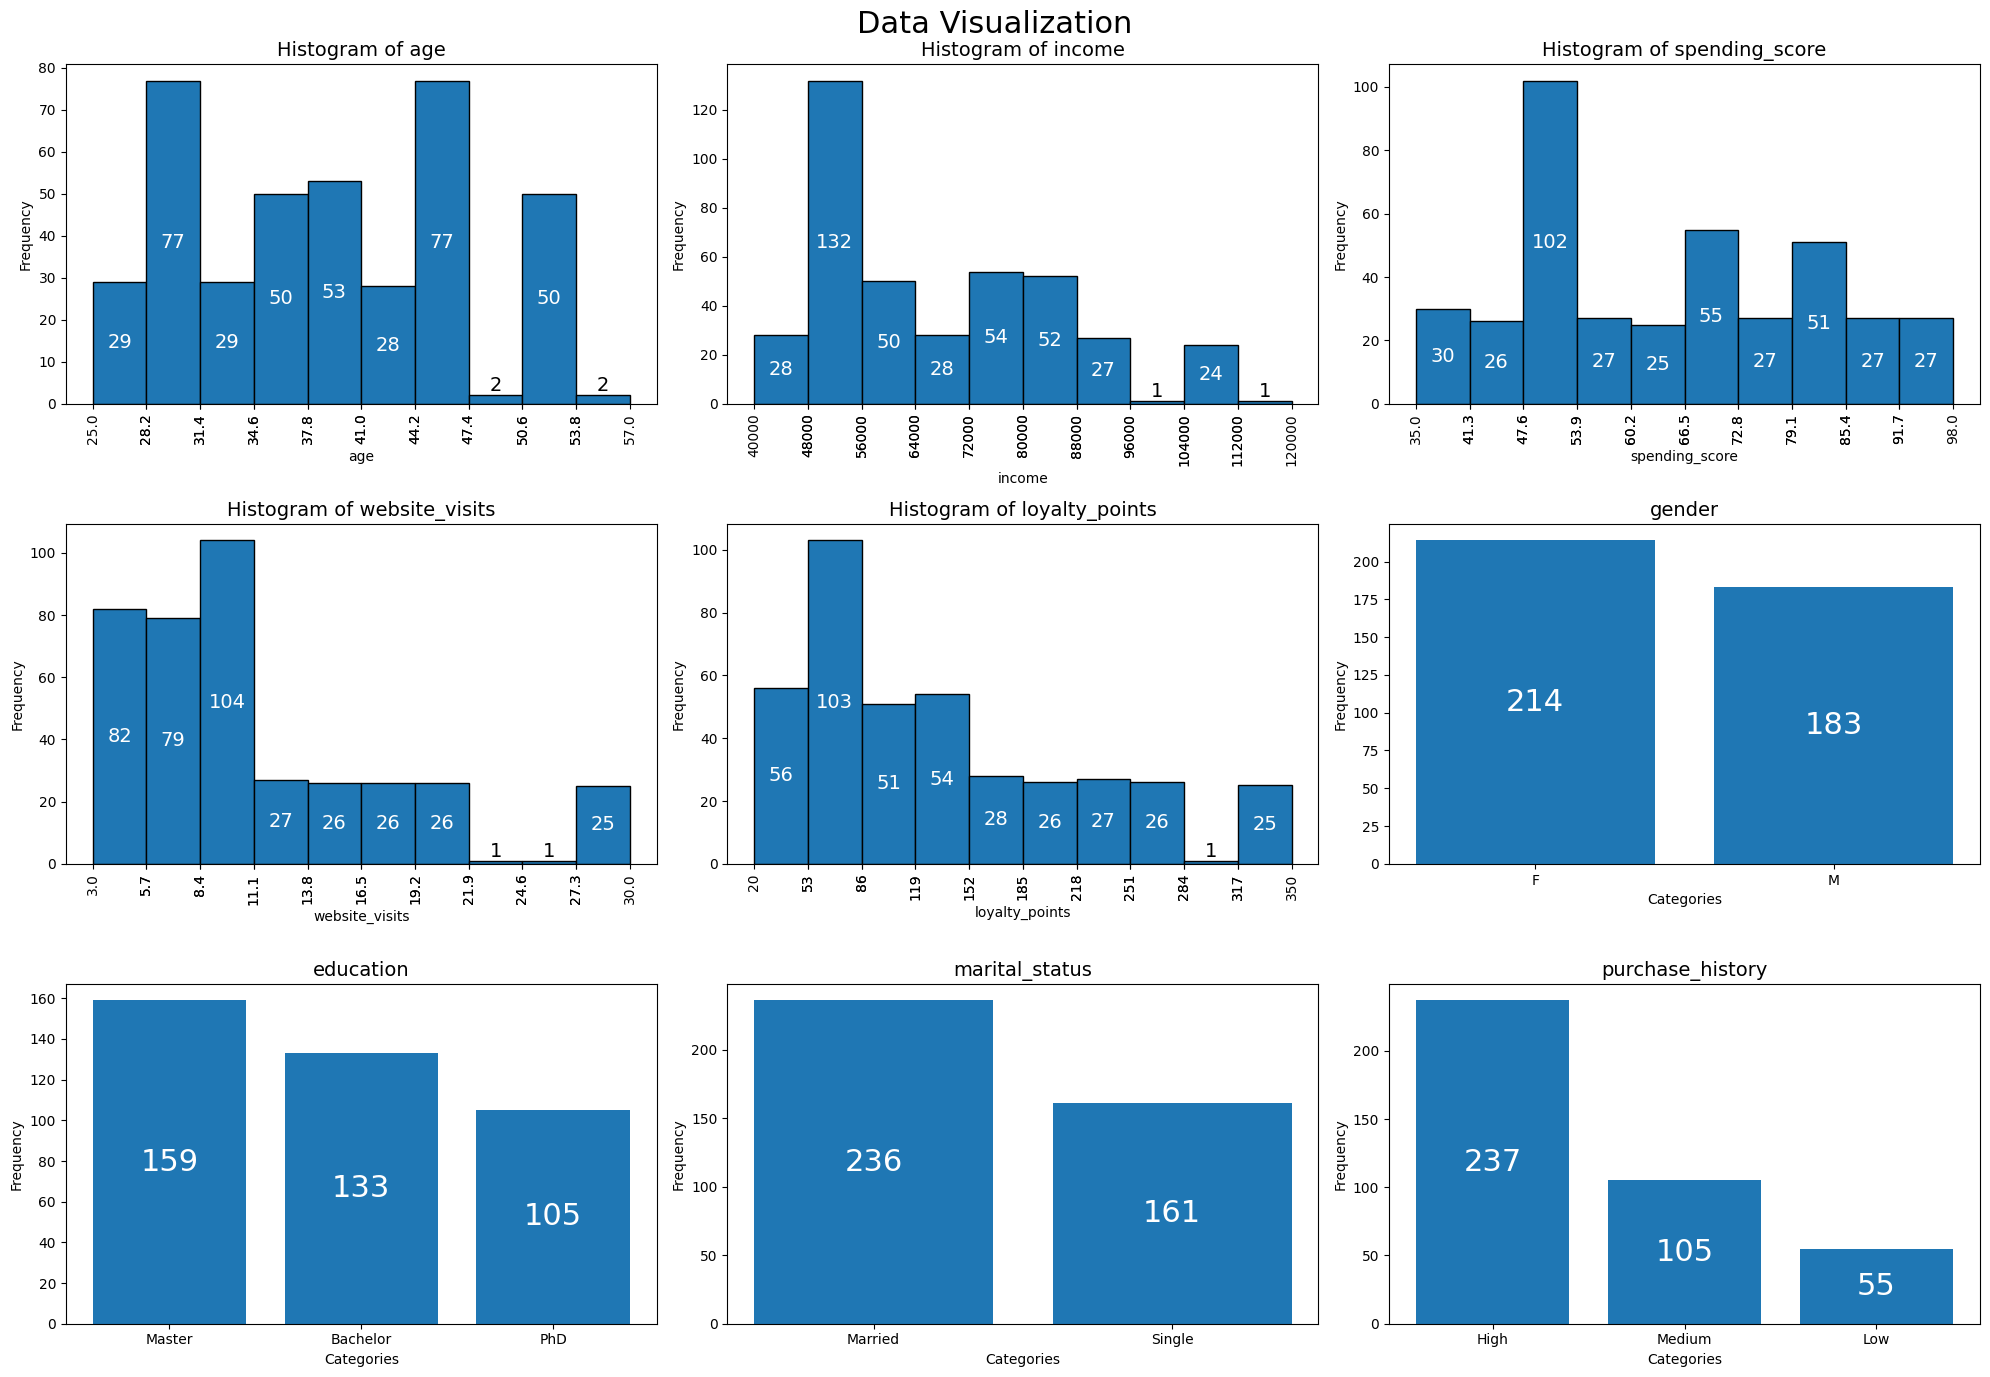

In [9]:
numeric_features = ['age', 'income', 'spending_score', 'website_visits', 'loyalty_points']
categorical_features = ['gender', 'education', 'marital_status', 'purchase_history']
visualize_data(df,'Data Visualization',numeric_features,categorical_features )


# Label encoding of categorical features
### ['gender','purchase_history','marital_status']

In [11]:
purchase_history_label_mapping = {
    'Low': 0,
    'Medium': 1,
    'High': 2
}

gender_label_mapping = {
    'F': 0,
    'M': 1

}

marital_status_label_mapping = {
    'Single': 0,
    'Married': 1

}

df['purchase_history'] = df['purchase_history'].map(purchase_history_label_mapping)
df['gender'] = df['gender'].map(gender_label_mapping)
df['marital_status'] = df['marital_status'].map(marital_status_label_mapping)
df

,age,gender,income,education,marital_status,spending_score,purchase_history,website_visits,loyalty_points
0,25,1,50000,Bachelor,0,70,2,10,100
1,35,0,60000,Master,1,50,1,5,50
2,45,0,80000,PhD,1,80,2,15,200
3,40,1,70000,Master,0,65,2,8,150
4,30,0,40000,Bachelor,0,35,0,3,20
...,...,...,...,...,...,...,...,...,...
392,36,0,52000,Bachelor,0,52,1,6,85
393,40,1,72000,Master,1,75,2,12,160
394,33,0,55000,Master,0,48,1,7,70
395,45,1,78000,Bachelor,1,70,2,10,140


# one hot encoding of 'education' feature

In [12]:
df['is_master'] = (df['education'] == 'Master').astype(int)
df['is_phd'] = (df['education'] == 'PhD').astype(int)

df = df.drop('education', axis=1)
df

,age,gender,income,marital_status,spending_score,purchase_history,website_visits,loyalty_points,is_master,is_phd
0,25,1,50000,0,70,2,10,100,0,0
1,35,0,60000,1,50,1,5,50,1,0
2,45,0,80000,1,80,2,15,200,0,1
3,40,1,70000,0,65,2,8,150,1,0
4,30,0,40000,0,35,0,3,20,0,0
...,...,...,...,...,...,...,...,...,...,...
392,36,0,52000,0,52,1,6,85,0,0
393,40,1,72000,1,75,2,12,160,1,0
394,33,0,55000,0,48,1,7,70,1,0
395,45,1,78000,1,70,2,10,140,0,0


# feature scaling for mumeric fueatures

In [13]:
import pickle
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[:] = scaler.fit_transform(df[:])

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

df

,age,gender,income,marital_status,spending_score,purchase_history,website_visits,loyalty_points,is_master,is_phd
0,-1.727283,1.081387,-0.986698,-1.210718,0.314977,0.747177,-0.106140,-0.440634,-0.817354,-0.599657
1,-0.495283,-0.924738,-0.421039,0.825956,-0.826473,-0.632494,-0.866748,-1.001132,1.223460,-0.599657
2,0.736718,-0.924738,0.710280,0.825956,0.885702,0.747177,0.654467,0.680363,-0.817354,1.667619
3,0.120717,1.081387,0.144621,-1.210718,0.029614,0.747177,-0.410383,0.119865,1.223460,-0.599657
4,-1.111283,-0.924738,-1.552357,-1.210718,-1.682561,-2.012164,-1.170991,-1.337431,-0.817354,-0.599657
...,...,...,...,...,...,...,...,...,...,...
392,-0.372083,-0.924738,-0.873566,-1.210718,-0.712328,-0.632494,-0.714626,-0.608783,-0.817354,-0.599657
393,0.120717,1.081387,0.257753,0.825956,0.600340,0.747177,0.198103,0.231964,1.223460,-0.599657
394,-0.741683,-0.924738,-0.703868,-1.210718,-0.940618,-0.632494,-0.562505,-0.776933,1.223460,-0.599657
395,0.736718,1.081387,0.597148,0.825956,0.314977,0.747177,-0.106140,0.007765,-0.817354,-0.599657


# fitting the Kmeans algorithm

In [14]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [15]:
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans, f)

In [16]:
df['cluster'] = kmeans.labels_
df['cluster'].value_counts()

2    131
1     82
4     79
0     78
3     27
Name: cluster, dtype: int64

In [17]:
silhouette_avg = silhouette_score(df.iloc[:, :-1], df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5981532592652027


# Description of each cluster

In [18]:
data = pd.read_csv('/kaggle/input/customer-clustering/customer_data.csv', delimiter=',')
data.drop('customer_id', axis=1, inplace=True)
data['cluster'] = kmeans.labels_
cluster_characteristics = data.groupby('cluster').describe()
cluster_characteristics.to_csv('cluster_numeric_characteristics.csv', index=True)
print('numeric features description of each cluster')
cluster_characteristics

numeric features description of each cluster


age                                                    income  \
         count       mean       std   min   25%   50%   75%   max  count   
cluster                                                                    
0         78.0  48.025641  2.233013  45.0  46.0  47.0  51.0  53.0   78.0   
1         82.0  30.865854  4.033080  25.0  26.0  31.0  36.0  36.0   82.0   
2        131.0  40.679389  3.543721  35.0  39.0  40.0  44.0  45.0  131.0   
3         27.0  53.111111  1.050031  50.0  53.0  53.0  53.0  57.0   27.0   
4         79.0  31.025316  1.768490  27.0  29.0  31.0  33.0  35.0   79.0   

                        ... website_visits       loyalty_points              \
                  mean  ...            75%   max          count        mean   
cluster                 ...                                                   
0         85064.102564  ...           20.0  23.0           78.0  242.948718   
1         50414.634146  ...            6.0  10.0           82.0   69.207317   
2         67900.763359  ...           10.0  12.0          131.0  131.221374   
3        109259.259259  ...           28.0  30.0           27.0  344.444444   
4         52670.886076  ...            7.0   7.0           79.0   53.037975   

                                                       
               std    min    25%    50%    75%    max  
cluster                                                
0        29.148477  200.0  210.0  240.0  280.0  280.0  
1        16.319902   20.0   50.0   75.0   85.0  100.0  
2        22.154107  100.0  110.0  140.0  140.0  180.0  
3        21.182964  250.0  350.0  350.0  350.0  350.0  
4        17.272657   30.0   30.0   60.0   70.0   70.0  

[5 rows x 40 columns]

In [19]:
# Select the non-numeric features
non_numeric_features = ['gender', 'education', 'marital_status', 'purchase_history']

# Create an empty DataFrame to store the results
characteristics_df = pd.DataFrame(index=sorted(data['cluster'].unique()))

# Iterate over the non-numeric features
for feature in non_numeric_features:
    # Group the data by cluster and feature, and calculate the count of each unique value
    feature_counts = data.groupby(['cluster', feature])[feature].count().unstack(fill_value=0)

    # Add the feature counts to the characteristics DataFrame
    characteristics_df = pd.concat([characteristics_df, feature_counts], axis=1)

# Fill missing values with 0
characteristics_df.fillna(0, inplace=True)
characteristics_df.to_csv('cluster_categories_characteristics.csv', index=True)
# Print the characteristics DataFrame
print('description of categorical features in each cluster')
characteristics_df

description of categorical features in each cluster


,F,M,Bachelor,Master,PhD,Married,Single,High,Low,Medium
0,78,0,0,0,78,78,0,78,0,0
1,31,51,82,0,0,1,81,1,28,53
2,26,105,51,80,0,130,1,131,0,0
3,0,27,0,0,27,26,1,27,0,0
4,79,0,0,79,0,1,78,0,27,52


# Visualization of each cluster

## Cluster: 0

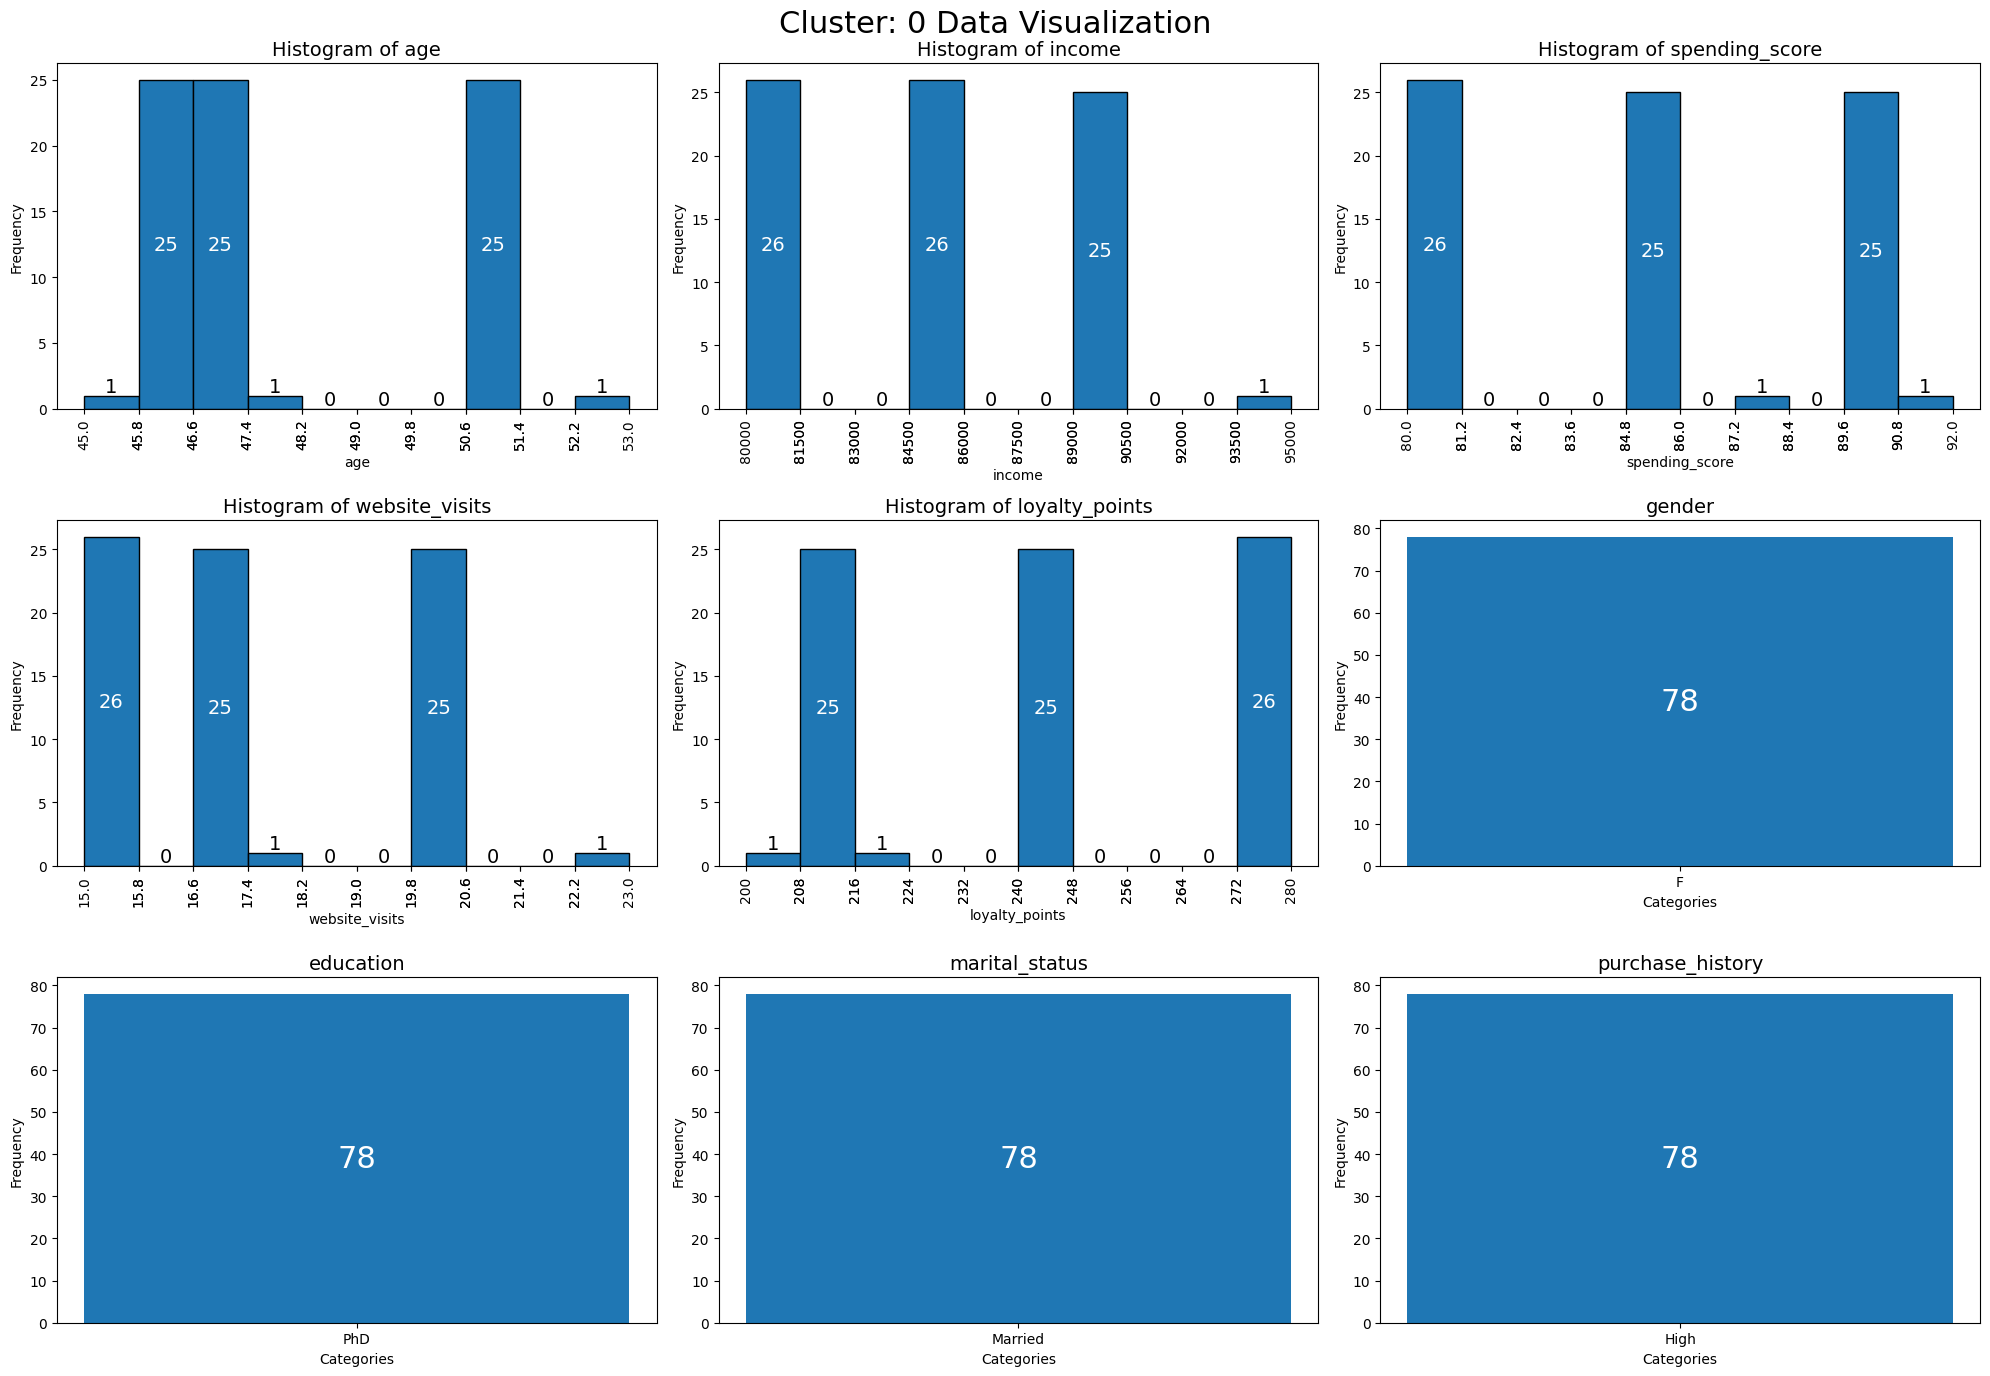

In [20]:
visualize_data(data[data['cluster']==0].drop('cluster', axis=1),'Cluster: 0 Data Visualization',numeric_features,categorical_features )

## Cluster: 1

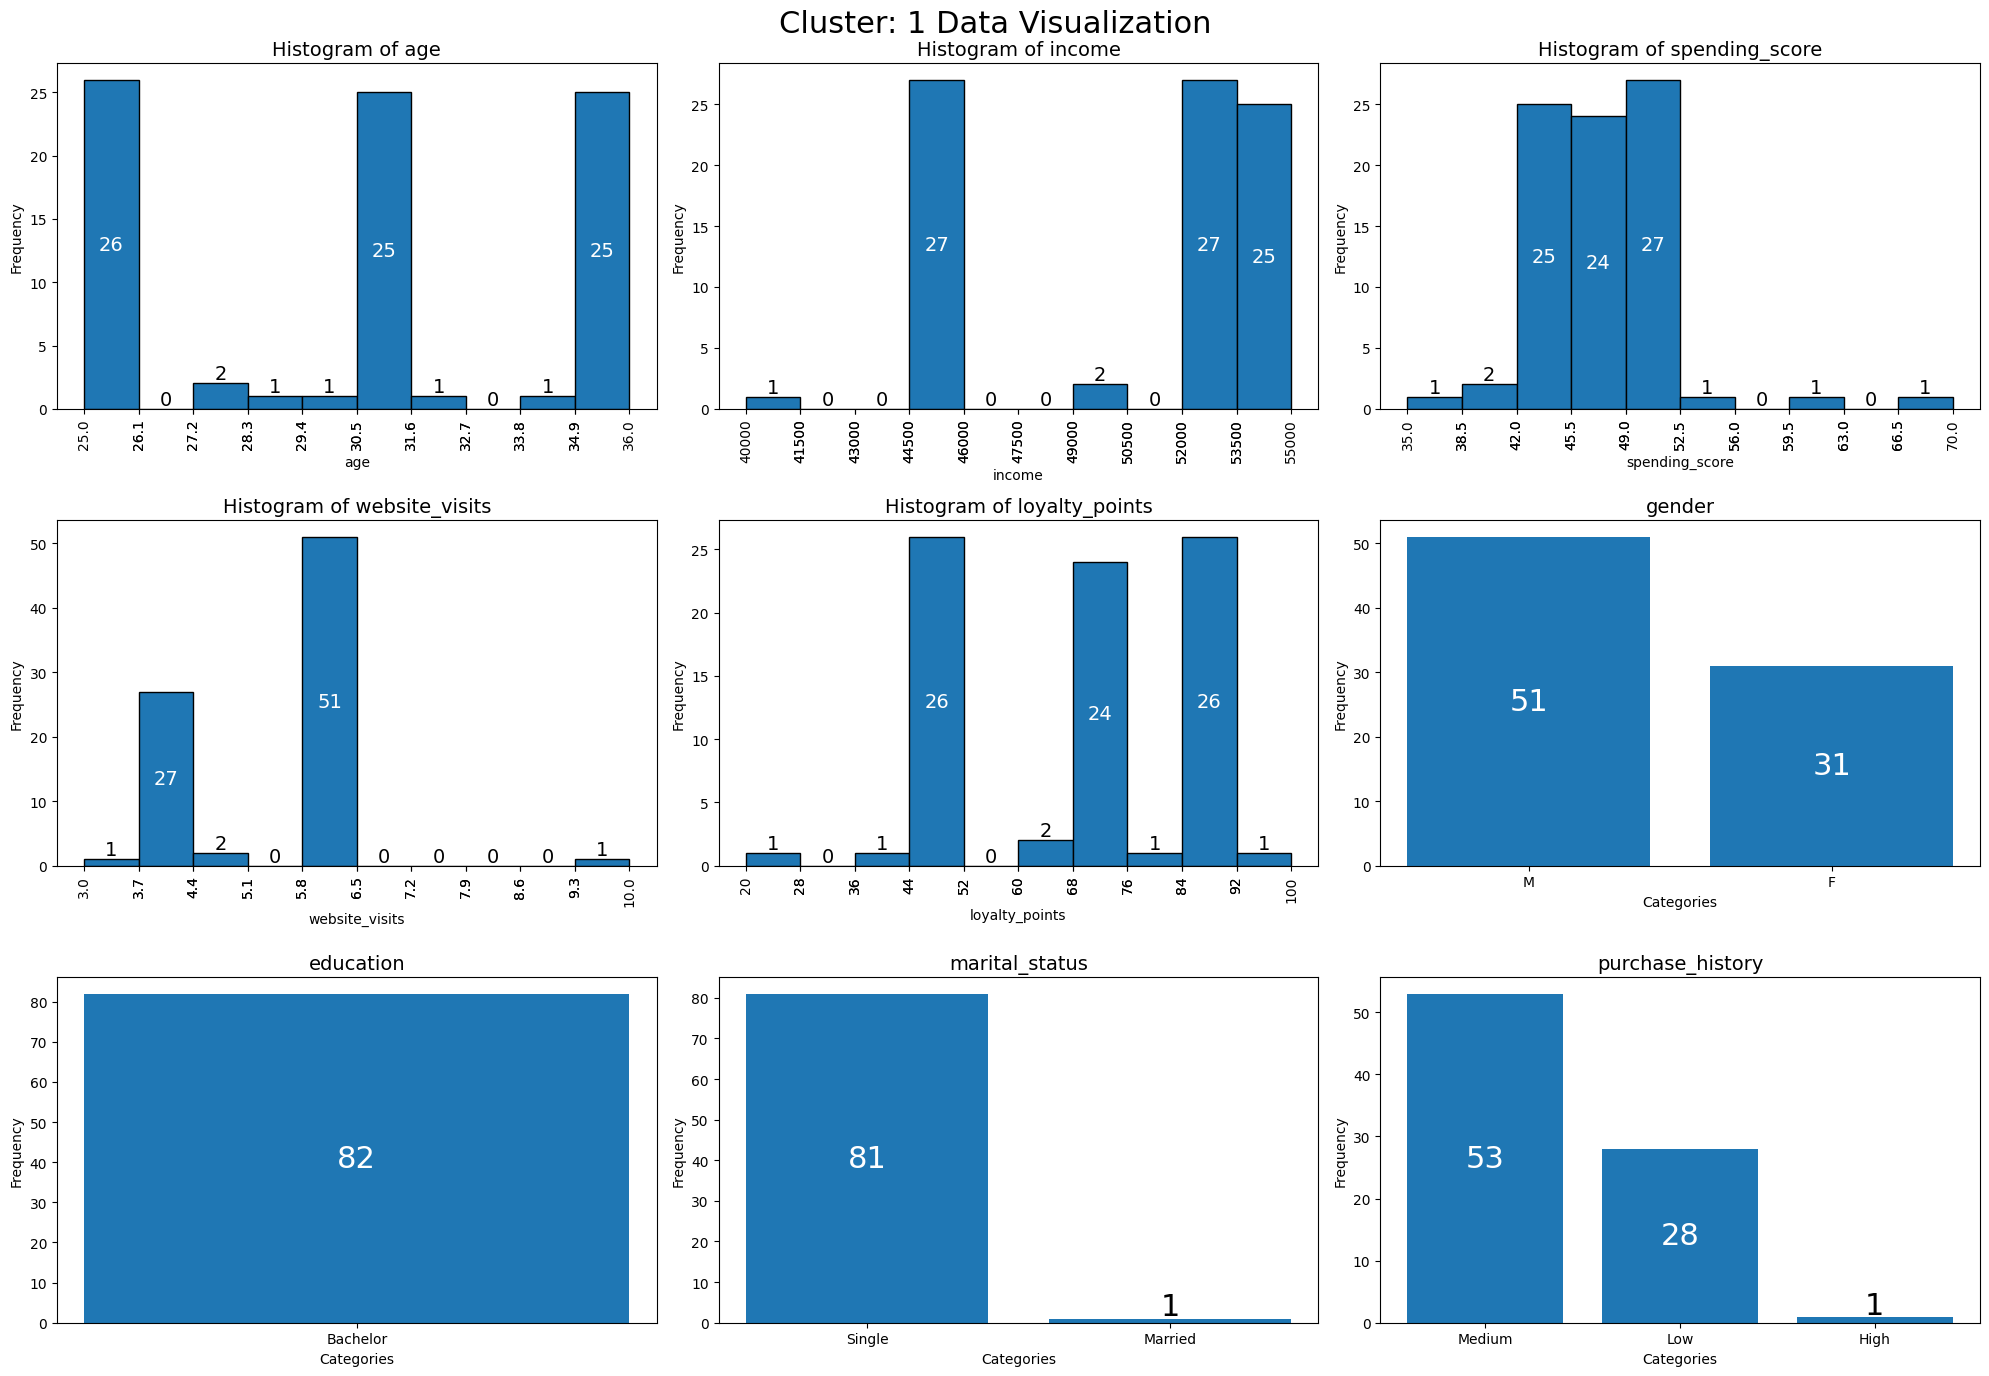

In [21]:
visualize_data(data[data['cluster']==1].drop('cluster', axis=1),'Cluster: 1 Data Visualization',numeric_features,categorical_features )

## Cluster: 2

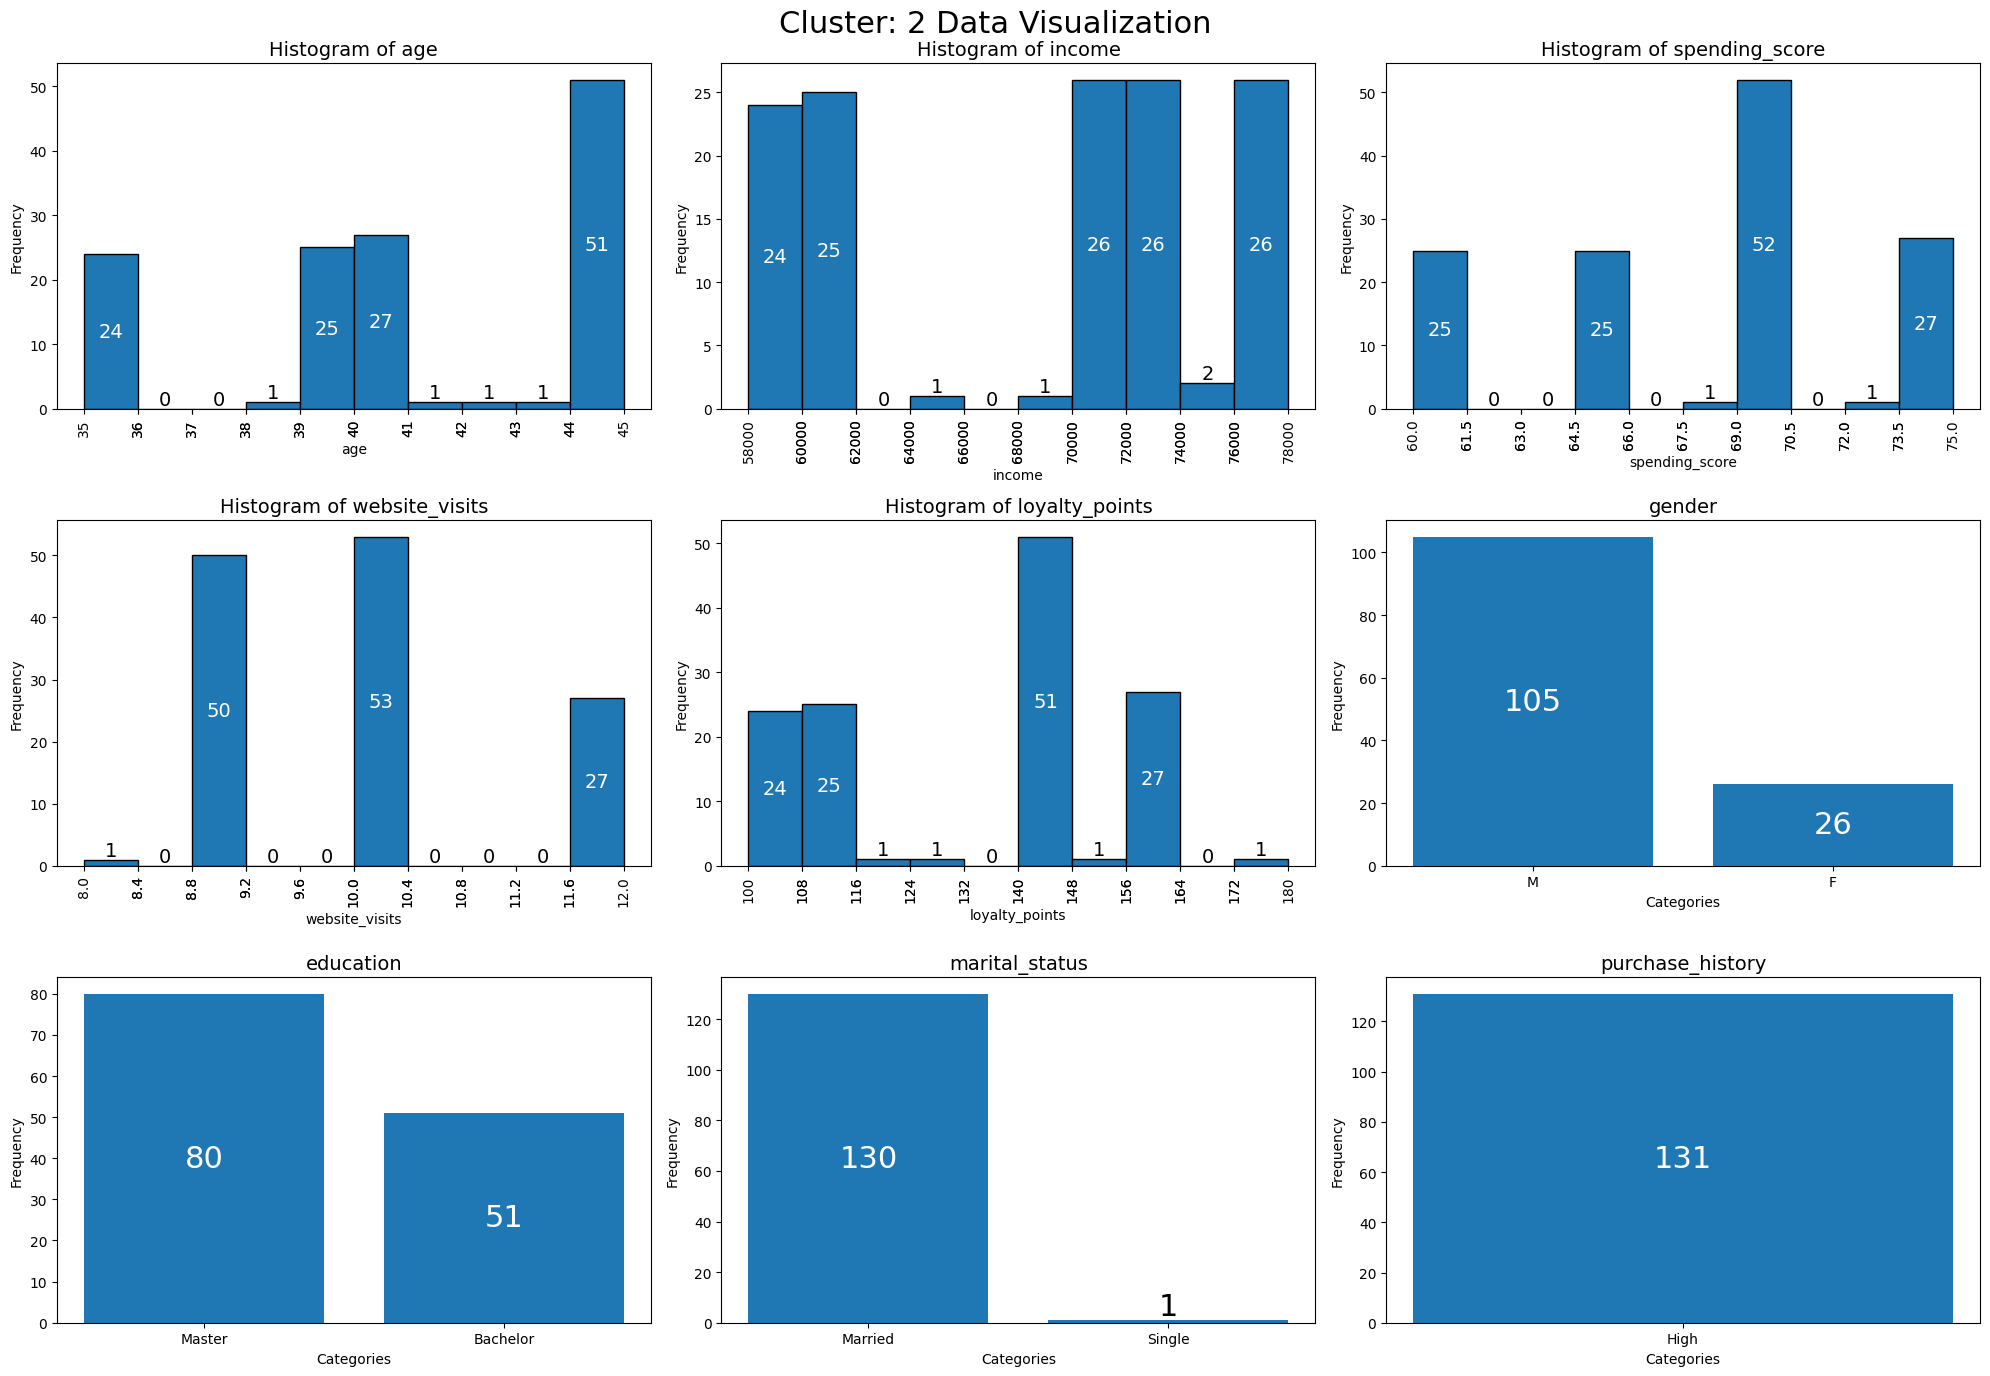

In [22]:
visualize_data(data[data['cluster']==2].drop('cluster', axis=1),'Cluster: 2 Data Visualization',numeric_features,categorical_features )

## Cluster: 3

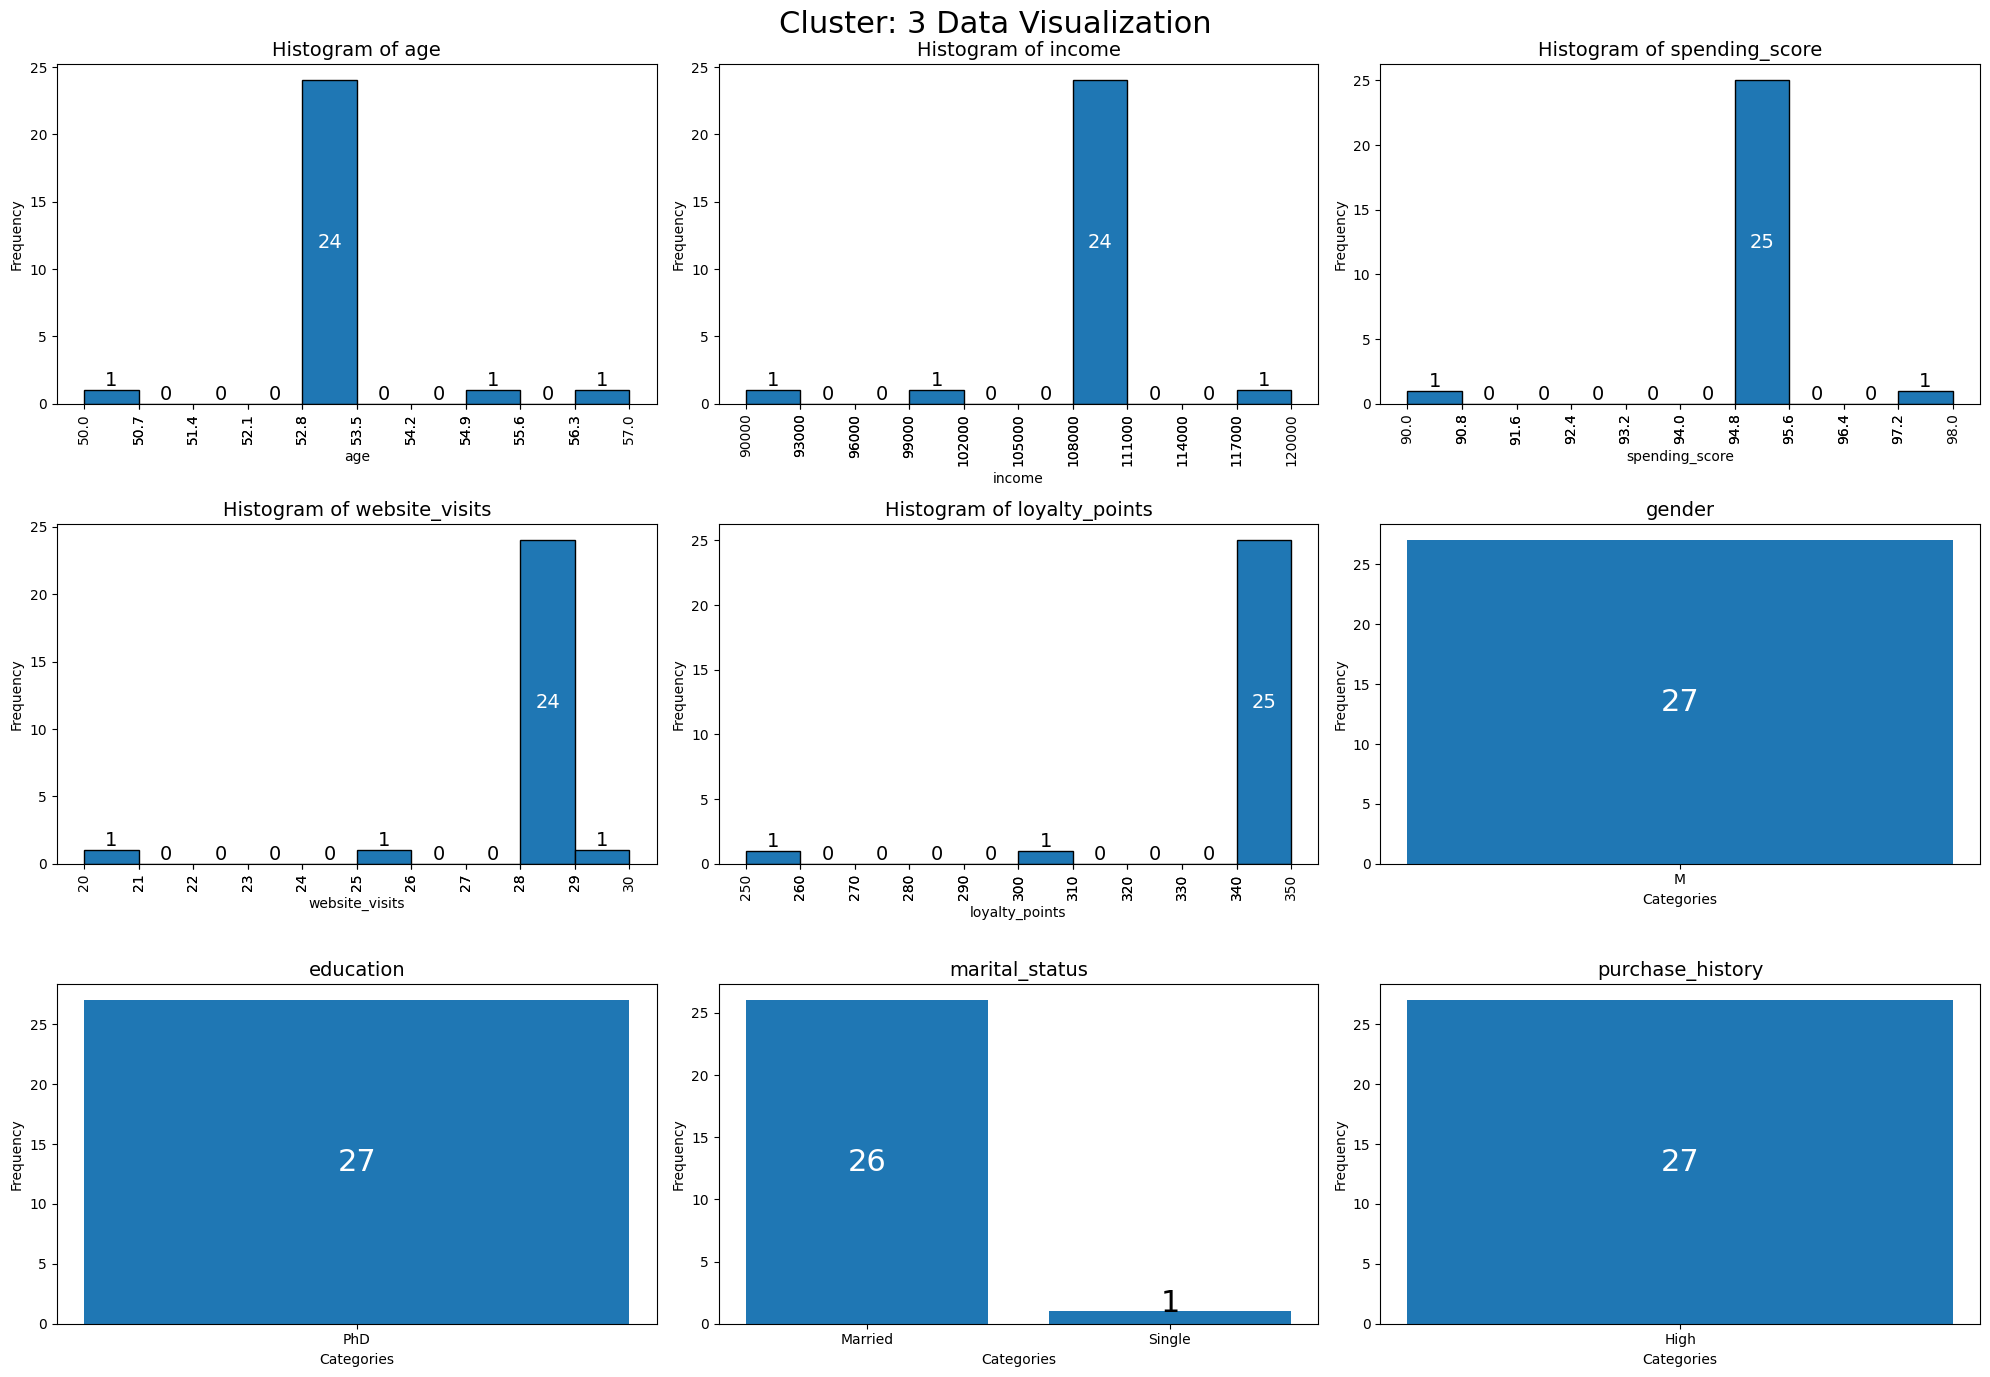

In [23]:
visualize_data(data[data['cluster']==3].drop('cluster', axis=1),'Cluster: 3 Data Visualization',numeric_features,categorical_features )

## Cluster: 4

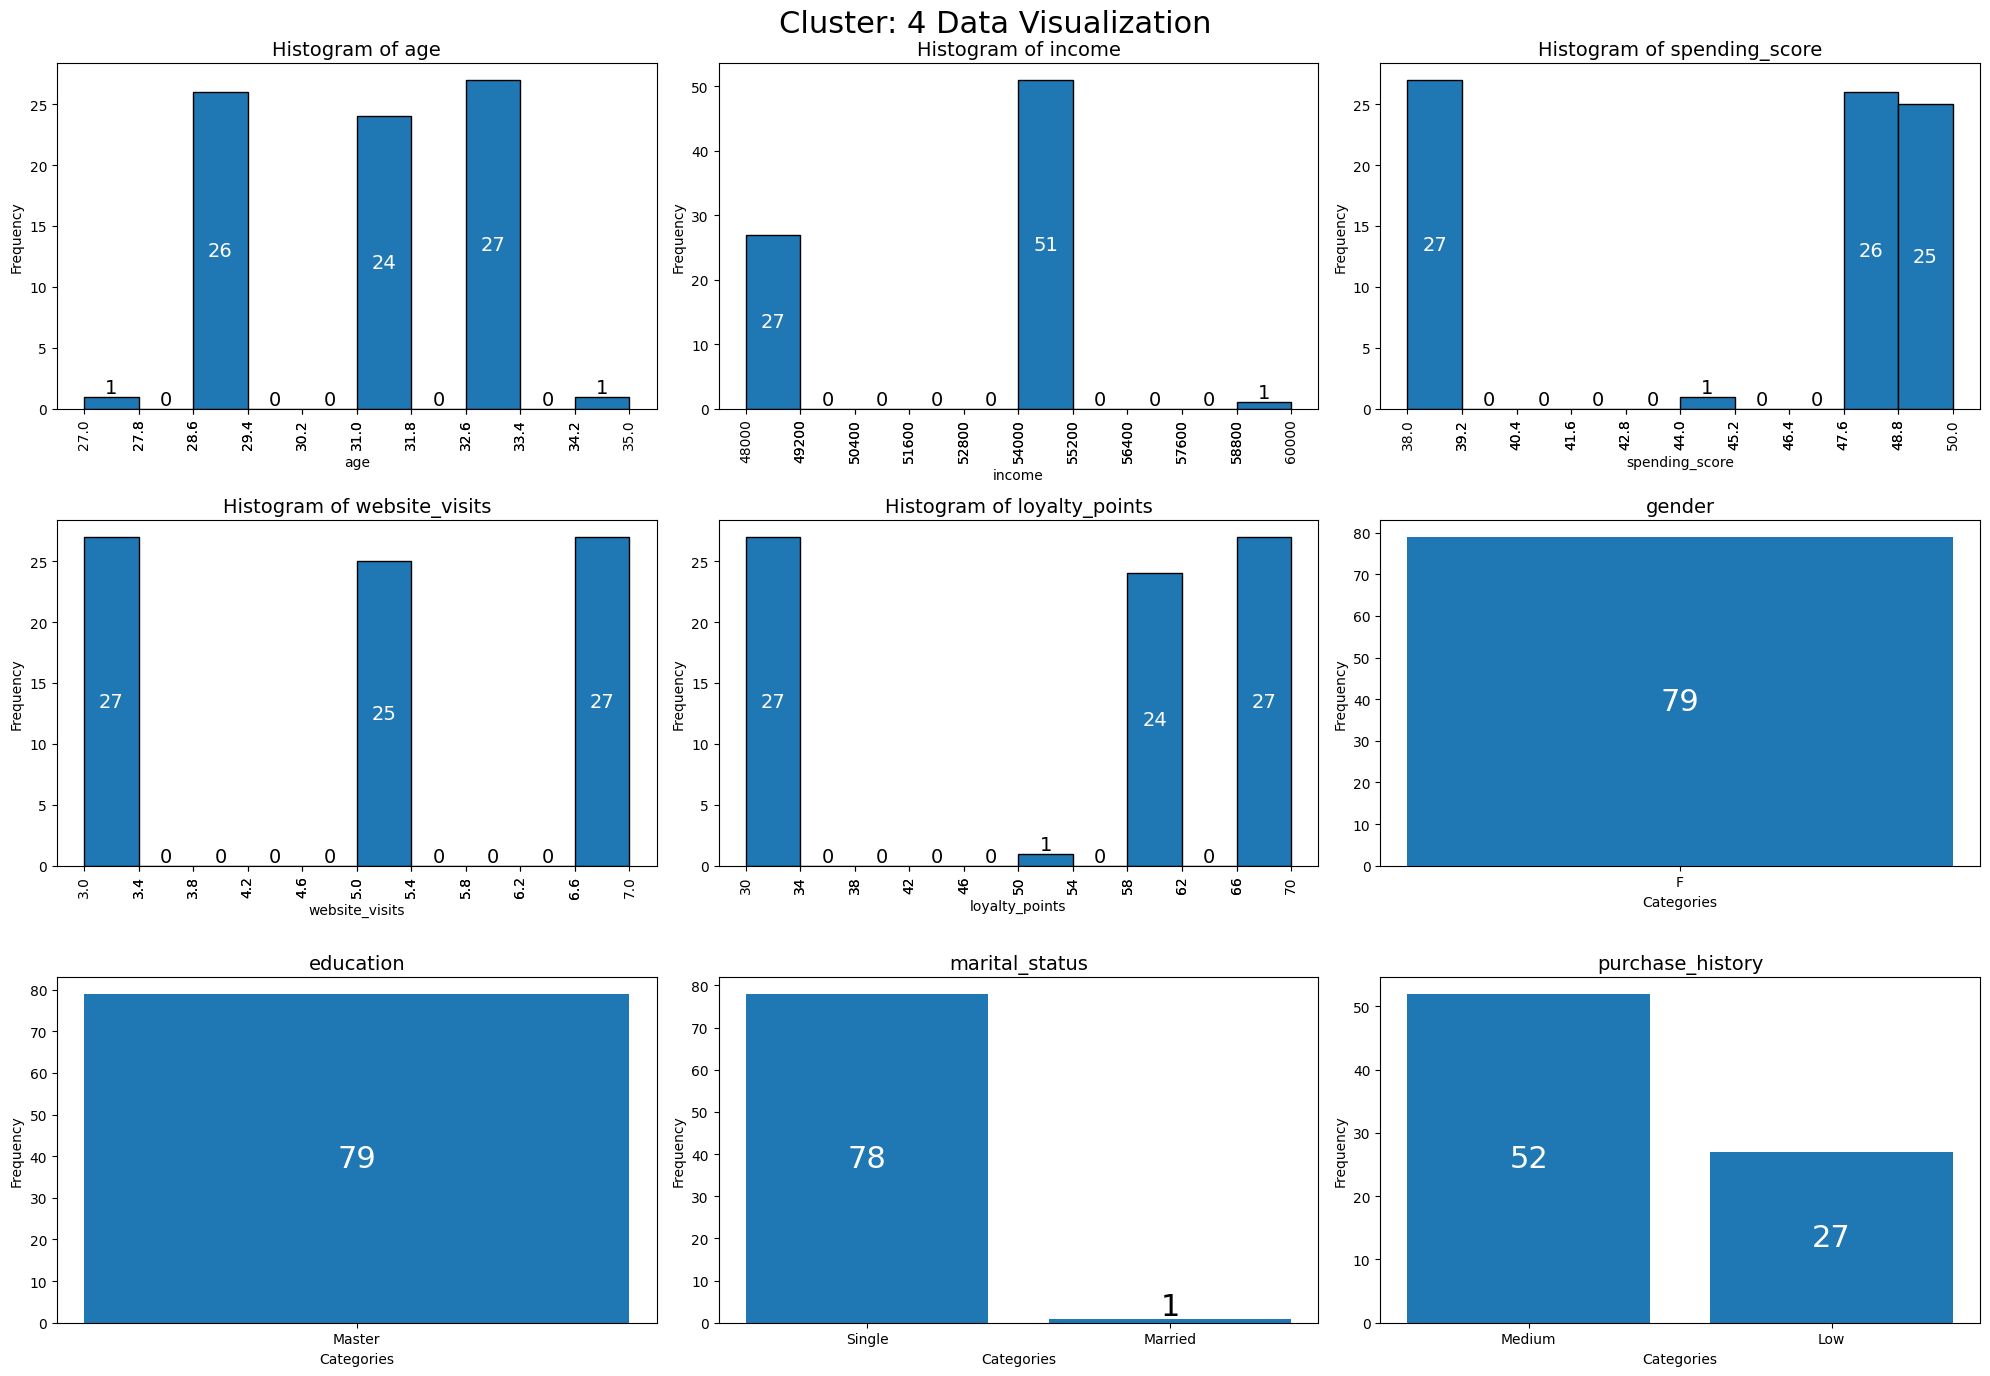

In [24]:
visualize_data(data[data['cluster']==4].drop('cluster', axis=1),'Cluster: 4 Data Visualization',numeric_features,categorical_features )

# Deployment

# creating a preprocessing function

In [25]:
def preprocess(df):
    purchase_history_label_mapping = {
        'Low': 0,
        'Medium': 1,
        'High': 2
    }

    gender_label_mapping = {
        'F': 0,
        'M': 1

    }

    marital_status_label_mapping = {
        'Single': 0,
        'Married': 1

    }



    df['purchase_history'] = df['purchase_history'].map(purchase_history_label_mapping)
    df['gender'] = df['gender'].map(gender_label_mapping)
    df['marital_status'] = df['marital_status'].map(marital_status_label_mapping)

    df['is_master'] = (df['education'] == 'Master').astype(int)
    df['is_phd'] = (df['education'] == 'PhD').astype(int)
    df = df.drop('education', axis=1)


    # feature scaling for numeric feaatures
    with open('scaler.pkl', 'rb') as f:
        loaded_scaler = pickle.load(f)
    df[:] = loaded_scaler.transform(df[:])
    return df

# load the  fitted Kmeans and make predictions on a new sample

In [26]:
#load fitted Kmeans
with open('kmeans_model.pkl', 'rb') as f:
    loaded_kmeans = pickle.load(f)

new_sample = [[25, 'M', 50000, 'Bachelor', 'Single', 70, 'High', 10, 100]]

# Column labels
column_labels = ['age', 'gender', 'income', 'education', 'marital_status', 'spending_score', 'purchase_history', 'website_visits', 'loyalty_points']

# Create DataFrame from the array with column labels
df = pd.DataFrame(new_sample, columns=column_labels)

# apply feature encoding and fearture scaling
preprocessed_df = preprocess(df)

# make prediction
loaded_kmeans.predict(preprocessed_df)[0]

1